In [1]:

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install Detectron2 (Pre-compiled wheel for Colab/CUDA 11.8)
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# pycocotools for COCO dataset handling
!pip install pycocotools

!pip install opencv-python

print("Environment setup complete!")

Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-zfru8kc1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-zfru8kc1
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.4 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733355 sha256=d8a0057a13ec93e4787e4a55581628e8ceb6d4920dad15cfa9d7214aa60a0ad8
  Stored in directory: /tmp/pip-

In [2]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import necessary modules from Detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import shutil
import random

# Download a small sample of COCO val2017 data (images and annotations)
# Using a direct link to a small subset for quick demonstration
# In practice, you might download the full val set or use the COCO API
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip the downloaded files
!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

# Define paths
original_images_dir = "val2017"
original_annotations_file = "annotations/instances_val2017.json"
cropped_images_dir = "cropped_val2017"
cropped_annotations_file = "annotations/instances_val2017_cropped.json"

# Create directory for cropped images
os.makedirs(cropped_images_dir, exist_ok=True)

# Load the original COCO annotations
coco = COCO(original_annotations_file)

print("Dataset loaded.")

--2025-09-04 02:28:38--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.199.33, 52.216.43.113, 3.5.27.127, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.199.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  17.8MB/s    in 47s     

2025-09-04 02:29:26 (16.4 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2025-09-04 02:29:26--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.231.145, 16.182.34.161, 3.5.25.196, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.231.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 1

In [3]:

# Create a Detectron2 config and load the PANOPTIC model from the model zoo
# This model segments "stuff" like sky
cfg = get_cfg()
config_file = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)
# Set the model to evaluation mode
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a detection threshold for thing classes

# Creating the predictor
predictor = DefaultPredictor(cfg)

print("Detectron2 PANOPTIC model loaded.")


[09/04 02:30:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:01, 180MB/s]                           


Detectron2 PANOPTIC model loaded.


In [4]:

def find_skyline_panoptic(image, predictions, coco_metadata):
    """
    Finds the skyline using panoptic segmentation output.
    Identifies the lowest row belonging to the 'sky' class.
    """
    height, width = image.shape[:2]

    # Panoptic segmentation output
    panoptic_seg, segments_info = predictions["panoptic_seg"]

    # --- Find the 'sky' class ID ---
    # The COCO panoptic dataset uses ID 180 for the 'sky' stuff class.

    SKY_CLASS_ID_COCO = 180
    # The panoptic_seg contains semantic IDs. For COCO, stuff classes like sky
    # are numbered >= 1000. The actual ID in the tensor is class_id * instance_id_multiplier + instance_id.
    # However, Detectron2's predictor output simplifies this.
    # The segments_info list contains dicts with 'id' (the value in panoptic_seg)
    # and 'category_id' (the original COCO class ID).
    sky_segment_id = None
    for segment in segments_info:
        if segment["category_id"] == SKY_CLASS_ID_COCO:
            sky_segment_id = segment["id"]
            break

    if sky_segment_id is None:
        print("Sky class not detected in this image.")
        # Fallback: Assume top third is sky or find first object row (like before)
        masks = predictions["instances"].pred_masks.cpu().numpy() if "instances" in predictions else np.array([])
        if len(masks) > 0:
            combined_mask = np.any(masks, axis=0)
            search_limit = height // 2
            for row in range(search_limit):
                if np.any(combined_mask[row, :]):
                    buffer = 10
                    print("Fallback to object detection heuristic.")
                    return max(0, row - buffer)
        print("Fallback: Defaulting skyline to top third.")
        return height // 3

    # --- Extract the sky mask ---
    # panoptic_seg is a tensor [1, H, W] containing segment IDs
    # Convert to numpy for easier handling
    panoptic_seg_np = panoptic_seg.squeeze().cpu().numpy() # Shape: [H, W]

    # Create a boolean mask for sky pixels
    sky_mask = (panoptic_seg_np == sky_segment_id)

    # --- Find the lowest row containing sky ---
    # Iterate from the bottom up to find the first sky pixel row
    for row in reversed(range(height)):
        if np.any(sky_mask[row, :]):
            # Found the lowest row with sky, crop just below this row
            # Add a small buffer to ensure we cut *below* the last sky pixel
            buffer = 5
            crop_row = min(height, row + buffer)
            print(f"Sky detected. Cropping at row: {crop_row} (Sky ended at row {row})")
            return crop_row

    # This shouldn't happen if sky_segment_id was found, but just in case
    print("Sky segment ID found but no pixels? Defaulting.")
    return height // 3




def crop_image_and_annotations(image_id, coco_api, predictor, cropped_images_dir):
    """
    Crops an image and its annotations based on the detected skyline.
    Returns the new annotations for this image.
    """
    # --- Load Image ---
    img_info = coco_api.loadImgs(image_id)[0]
    image_path = os.path.join(original_images_dir, img_info['file_name'])
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image {image_path}")
        return [], None

    original_height, original_width = image.shape[:2]

    # --- Run Detection ---
    outputs = predictor(image)
    # Uncomment below to visualize detections on the original image
    # v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    # out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # plt.figure(figsize=(12, 8))
    # plt.imshow(out.get_image()[:, :, ::-1])
    # plt.title(f"Detections for {img_info['file_name']}")
    # plt.axis('off')
    # plt.show()

    # --- Find Skyline ---
        # --- Find Skyline using Panoptic Output ---
    # Get COCO metadata to find class names/IDs if needed (optional here, but good practice)
    # Metadata is usually loaded automatically when using model zoo configs
    # coco_metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0] if cfg.DATASETS.TRAIN else "coco_2017_val_panoptic") # Safer way if unsure
    coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic") # Standard name for COCO val panoptic metadata
    skyline_row = find_skyline_panoptic(image, outputs, coco_metadata)
    print(f"Estimated skyline row for {img_info['file_name']}: {skyline_row}")
    # --- End Find Skyline ---

    # --- Crop Image ---
    if skyline_row >= original_height - 1:
        print("Skyline is at or near the bottom, no significant crop.")
        cropped_image = image.copy()
        crop_offset_y = 0
    else:
        cropped_image = image[skyline_row:, :] # Crop from skyline_row to bottom
        crop_offset_y = skyline_row

    cropped_height, cropped_width = cropped_image.shape[:2]

    # Save cropped image
    cropped_image_path = os.path.join(cropped_images_dir, img_info['file_name'])
    success = cv2.imwrite(cropped_image_path, cropped_image)
    if not success:
        print(f"Failed to save cropped image {cropped_image_path}")
        return [], None

    # --- Adjust Annotations ---
    ann_ids = coco_api.getAnnIds(imgIds=image_id)
    anns = coco_api.loadAnns(ann_ids)

    new_annotations = []
    for ann in anns:
        # --- Adjust Bounding Box ---
        bbox = ann['bbox'] # [x, y, width, height] (COCO format)
        x, y, w, h = bbox
        new_y = y - crop_offset_y

        # Check if annotation is entirely above the crop
        if new_y + h <= 0:
            # print(f"Annotation {ann['id']} is entirely above the crop, discarding.")
            continue # Discard

        # Adjust bbox coordinates
        new_bbox = [x, max(0, new_y), w, h] # Ensure y doesn't go negative
        # Adjust height if part is cropped
        if new_y < 0:
             new_bbox[3] = h + new_y # Reduce height by the amount cropped off the top

        # --- Adjust Segmentation Mask ---
        new_segmentation = []
        if 'segmentation' in ann and ann['segmentation']:
            if isinstance(ann['segmentation'], list): # Polygon format
                for poly in ann['segmentation']:
                    new_poly = []
                    for i in range(0, len(poly), 2):
                        px, py = poly[i], poly[i+1]
                        new_py = py - crop_offset_y
                        # Only keep points that are within the new image bounds (roughly)
                        # A more robust check would be needed for complex polygons
                        if new_py >= -10 and new_py <= cropped_height + 10: # Allow some buffer
                            new_poly.append(px)
                            new_poly.append(max(0, new_py)) # Clamp to new image top
                    if len(new_poly) >= 6: # Need at least 3 points for a polygon
                         new_segmentation.append(new_poly)
            # else: # RLE format - more complex to adjust, skipped for now

        # --- Create New Annotation ---
        new_ann = ann.copy()
        new_ann['bbox'] = new_bbox
        new_ann['segmentation'] = new_segmentation if new_segmentation else [] # Update or clear
        new_ann['image_id'] = image_id # Image ID stays the same
        new_ann['id'] = ann['id'] # Keep original annotation ID (or generate new if needed)
        # Update area if needed (optional, but good practice)
        # new_ann['area'] = new_bbox[2] * new_bbox[3] # Simple area from bbox
        new_annotations.append(new_ann)

    # Return new annotations and image info for the new dataset
    new_img_info = img_info.copy()
    new_img_info['height'] = cropped_height
    new_img_info['width'] = cropped_width

    return new_annotations, new_img_info

print("Skyline detection and cropping functions defined.")

Skyline detection and cropping functions defined.


In [5]:
# Get a list of image IDs
img_ids = list(coco.imgs.keys())
# Shuffle and take a small sample for demonstration
random.shuffle(img_ids)
sample_img_ids = img_ids[:5] # Process first 5 images

# Lists to store new annotations and image info
all_new_annotations = []
all_new_image_info = []

print(f"Processing {len(sample_img_ids)} images...")
for i, img_id in enumerate(sample_img_ids):
    print(f"--- Processing Image {i+1}/{len(sample_img_ids)} (ID: {img_id}) ---")
    new_anns, new_img_info = crop_image_and_annotations(img_id, coco, predictor, cropped_images_dir)
    if new_anns is not None and new_img_info is not None:
        all_new_annotations.extend(new_anns)
        all_new_image_info.append(new_img_info)
    print("-" * 20)

print("Image processing complete.")

Processing 5 images...
--- Processing Image 1/5 (ID: 71938) ---


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Sky class not detected in this image.
Fallback to object detection heuristic.
Estimated skyline row for 000000071938.jpg: 0
--------------------
--- Processing Image 2/5 (ID: 266400) ---
Sky class not detected in this image.
Fallback to object detection heuristic.
Estimated skyline row for 000000266400.jpg: 0
--------------------
--- Processing Image 3/5 (ID: 435299) ---
Sky class not detected in this image.
Fallback to object detection heuristic.
Estimated skyline row for 000000435299.jpg: 31
--------------------
--- Processing Image 4/5 (ID: 251119) ---
Sky class not detected in this image.
Fallback to object detection heuristic.
Estimated skyline row for 000000251119.jpg: 39
--------------------
--- Processing Image 5/5 (ID: 239274) ---
Sky class not detected in this image.
Fallback to object detection heuristic.
Estimated skyline row for 000000239274.jpg: 245
--------------------
Image processing complete.


In [6]:
# Load the original annotations JSON to get categories, info, licenses
with open(original_annotations_file, 'r') as f:
    original_data = json.load(f)

# Create the new dataset dictionary
new_dataset = {
    "info": original_data.get("info", {}),
    "licenses": original_data.get("licenses", []),
    "images": all_new_image_info, # Use the updated image info
    "annotations": all_new_annotations, # Use the adjusted annotations
    "categories": original_data.get("categories", []) # Keep original categories
}

# Save the new annotations to a JSON file
with open(cropped_annotations_file, 'w') as f:
    json.dump(new_dataset, f, indent=4)

print(f"New COCO dataset JSON saved to {cropped_annotations_file}")

New COCO dataset JSON saved to annotations/instances_val2017_cropped.json


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


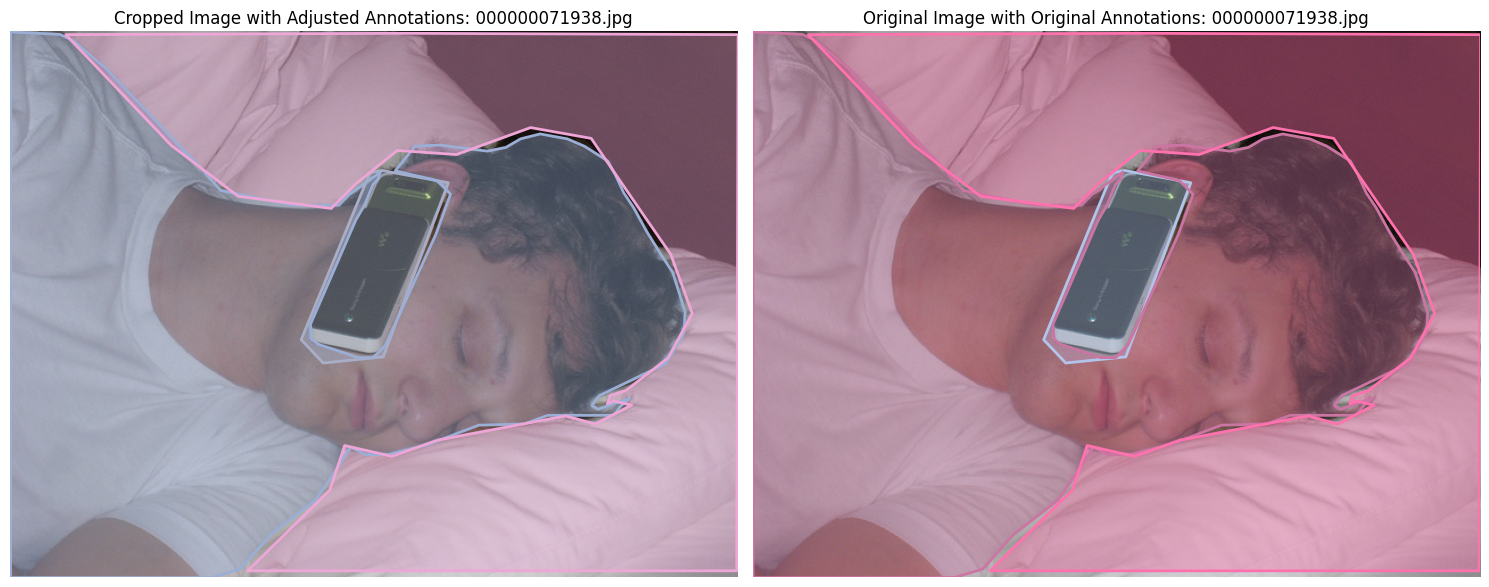

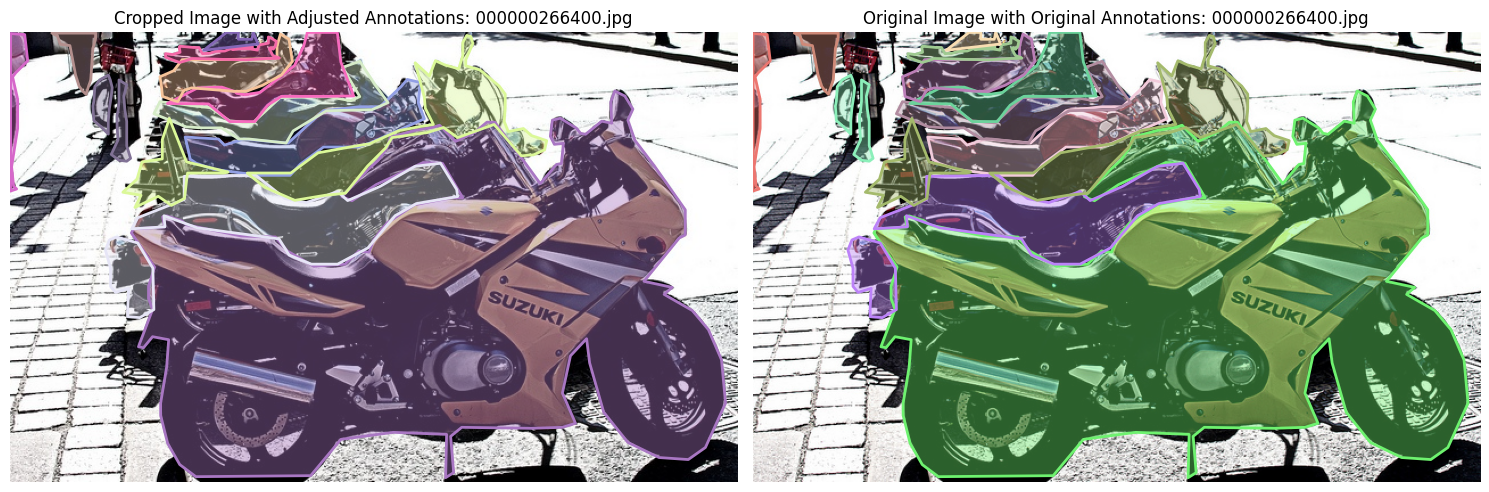

Visualization complete.


In [9]:
# Load the newly created cropped COCO dataset
coco_cropped = COCO(cropped_annotations_file)

# Get image IDs from the cropped dataset
cropped_img_ids = list(coco_cropped.imgs.keys())

# Visualize a couple of results
num_to_visualize = min(2, len(cropped_img_ids))

for i in range(num_to_visualize):
    img_id = cropped_img_ids[i]
    img_info = coco_cropped.loadImgs(img_id)[0]
    image_path = os.path.join(cropped_images_dir, img_info['file_name'])

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load cropped image {image_path} for visualization.")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for Matplotlib

    # Get annotations for this image
    ann_ids = coco_cropped.getAnnIds(imgIds=img_id)
    anns = coco_cropped.loadAnns(ann_ids)

    # Visualize using pycocotools (it handles adjusted annotations)
    plt.figure(figsize=(15, 10))

    # Show image with annotations
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    coco_cropped.showAnns(anns)
    plt.title(f"Cropped Image with Adjusted Annotations: {img_info['file_name']}")

    # Show original image with original annotations for comparison
    plt.subplot(1, 2, 2)
    orig_img_info = coco.loadImgs(img_id)[0]
    orig_image_path = os.path.join(original_images_dir, orig_img_info['file_name'])
    orig_image = cv2.imread(orig_image_path)
    if orig_image is not None:
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        orig_ann_ids = coco.getAnnIds(imgIds=img_id)
        orig_anns = coco.loadAnns(orig_ann_ids)
        plt.imshow(orig_image)
        plt.axis('off')
        coco.showAnns(orig_anns)
        plt.title(f"Original Image with Original Annotations: {orig_img_info['file_name']}")
    else:
        plt.text(0.5, 0.5, "Original image not found", ha='center', va='center')
        plt.title("Original Image")

    plt.tight_layout()
    plt.show()

print("Visualization complete.")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

--- Visualizing Results for Image ID: 71938 ---
Sky class not detected in this image.
Fallback to object detection heuristic.


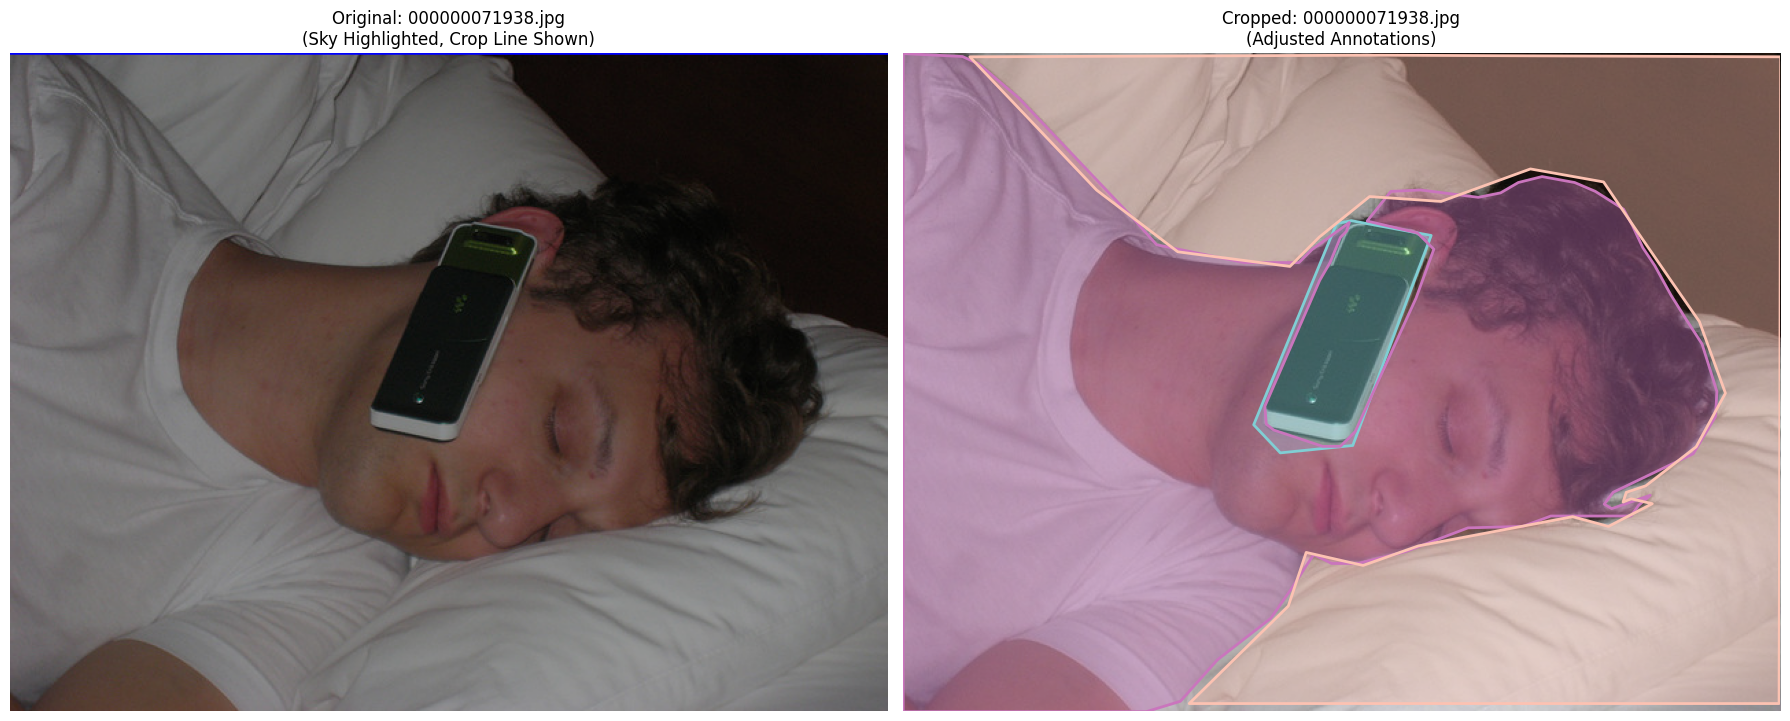


--- Visualizing Results for Image ID: 266400 ---
Sky class not detected in this image.
Fallback to object detection heuristic.


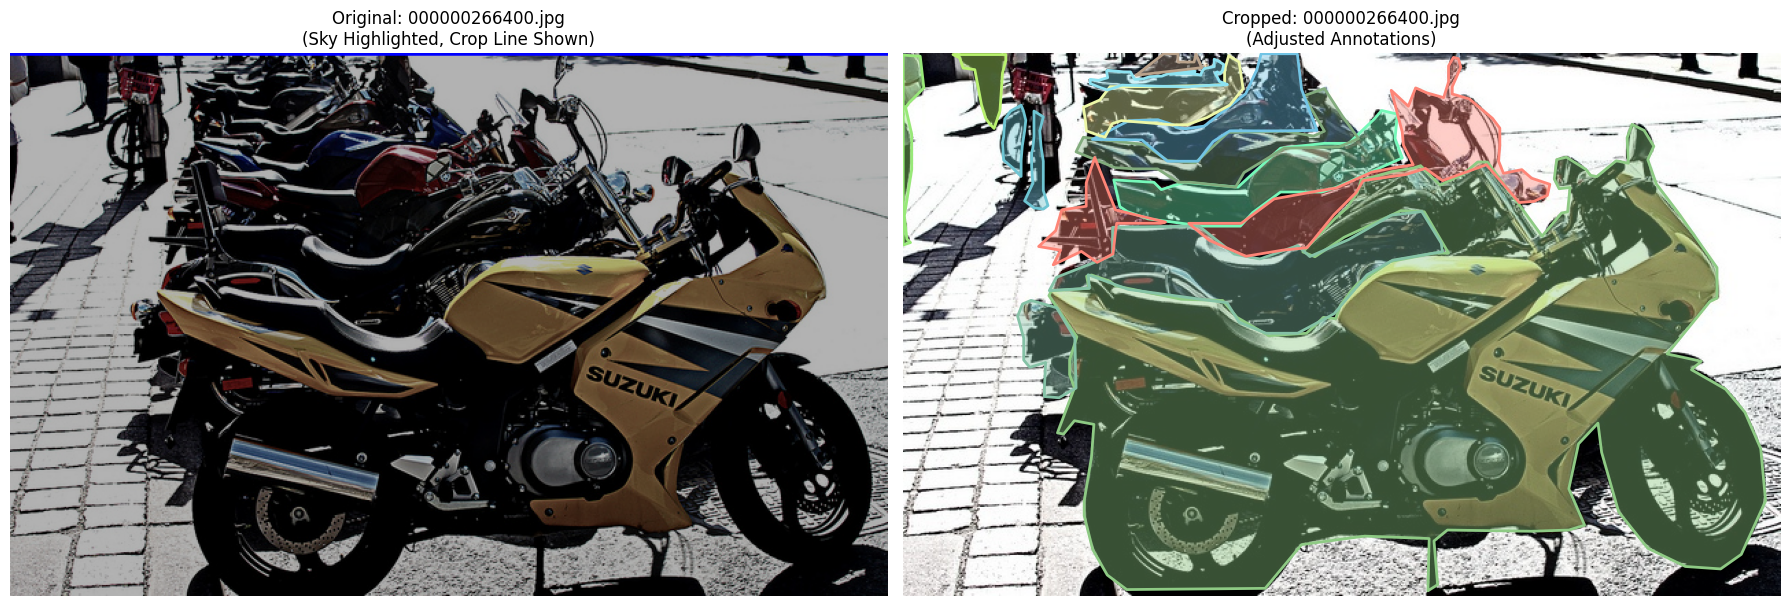

Corrected side-by-side visualization complete.


In [10]:
# --- UPDATE: Corrected Side-by-Side Visualization ---
# Load the newly created cropped COCO dataset for comparison
coco_cropped = COCO(cropped_annotations_file)

# Get image IDs from the cropped dataset
cropped_img_ids = list(coco_cropped.imgs.keys())

# --- Load Panoptic Metadata for Sky Visualization ---
panoptic_metadata = MetadataCatalog.get("coco_2017_val_panoptic")
SKY_CLASS_ID_COCO = 180 # Standard COCO Panoptic ID for 'sky'

# Visualize a couple of results
num_to_visualize = min(2, len(cropped_img_ids))

for i in range(num_to_visualize):
    img_id = cropped_img_ids[i]
    print(f"\n--- Visualizing Results for Image ID: {img_id} ---")

    # --- Load Cropped Image and Annotations ---
    cropped_img_info = coco_cropped.loadImgs(img_id)[0]
    cropped_image_path = os.path.join(cropped_images_dir, cropped_img_info['file_name'])
    cropped_image = cv2.imread(cropped_image_path)
    if cropped_image is None:
        print(f"Could not load cropped image {cropped_image_path} for visualization.")
        continue
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    cropped_ann_ids = coco_cropped.getAnnIds(imgIds=img_id)
    cropped_anns = coco_cropped.loadAnns(cropped_ann_ids)

    # --- Load Original Image and Run Prediction ---
    orig_img_info = coco.loadImgs(img_id)[0]
    orig_image_path = os.path.join(original_images_dir, orig_img_info['file_name'])
    orig_image = cv2.imread(orig_image_path)
    if orig_image is None:
        print(f"Could not load original image {orig_image_path} for visualization.")
        continue
    orig_image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    height, width = orig_image.shape[:2]

    # Re-run prediction on the original image to get panoptic output
    outputs = predictor(orig_image)

    # --- Prepare Visualization for Original Image ---
    # 1. Highlight the detected sky area
    image_with_sky_highlight = orig_image_rgb.copy()
    sky_mask_overlay = np.zeros_like(orig_image_rgb, dtype=np.uint8)
    if "panoptic_seg" in outputs:
        panoptic_seg, segments_info = outputs["panoptic_seg"]
        panoptic_seg_np = panoptic_seg.squeeze().cpu().numpy()
        sky_segment_id = None
        for segment in segments_info:
            if segment["category_id"] == SKY_CLASS_ID_COCO:
                sky_segment_id = segment["id"]
                break
        if sky_segment_id is not None:
            sky_mask = (panoptic_seg_np == sky_segment_id)
            # Use a distinct color for sky highlight (e.g., Cyan)
            sky_color = np.array([0, 255, 255], dtype=np.uint8) # BGR for OpenCV, will be RGB in Matplotlib
            sky_mask_overlay[sky_mask] = sky_color
    # Blend the sky highlight
    alpha_sky = 0.3
    image_with_sky_highlight = cv2.addWeighted(orig_image_rgb, 1 - alpha_sky, sky_mask_overlay, alpha_sky, 0)

    # 2. Draw the calculated crop line
    image_for_comparison = image_with_sky_highlight.copy()
    # Re-run skyline detection to get the line (or pass it from processing if stored)
    skyline_row_viz = find_skyline_panoptic(orig_image, outputs, panoptic_metadata)
    if 0 <= skyline_row_viz < height:
        cv2.line(image_for_comparison, (0, skyline_row_viz), (width, skyline_row_viz), (0, 0, 255), thickness=2) # Red line in BGR (appears red in RGB matplotlib)

    # --- Plotting: Side-by-Side Comparison ---
    plt.figure(figsize=(18, 8)) # Adjust figure size as needed

    # Subplot 1: Original Image with Sky Highlight and Crop Line
    plt.subplot(1, 2, 1)
    plt.imshow(image_for_comparison)
    plt.axis('off')
    plt.title(f"Original: {orig_img_info['file_name']}\n(Sky Highlighted, Crop Line Shown)")

    # Subplot 2: Cropped Image with Adjusted Annotations
    plt.subplot(1, 2, 2)
    plt.imshow(cropped_image_rgb) # Show the cropped image
    # Draw adjusted annotations using pycocotools directly on this axis
    coco_cropped.showAnns(cropped_anns)
    plt.axis('off')
    plt.title(f"Cropped: {cropped_img_info['file_name']}\n(Adjusted Annotations)")

    plt.tight_layout()
    plt.show()

print("Corrected side-by-side visualization complete.")
# --- END UPDATE ---